### Import the packages

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter

sns.set_style('whitegrid')

### Load dataset

In [2]:
# define column names for easy indexing
index_names = ['unit_num', 'time_cycles']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['sensor{}'.format(i) for i in range(1, 22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('data/train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('data/test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('data/RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# inspect first few rows
train.head()

,unit_num,time_cycles,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Exploratory data analysis

In [3]:
train.unit_num.unique().shape

(100,)

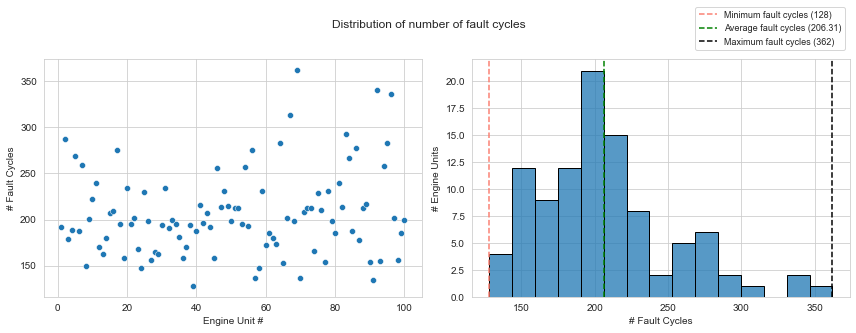

In [4]:
n_cycles = train[index_names].groupby('unit_num').count()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.scatterplot(data=n_cycles, x="unit_num", y="time_cycles", ax=axes[0])

hist = sns.histplot(data=n_cycles, x="time_cycles", edgecolor='k', ax=axes[1], bins=15)
hist.axvline(n_cycles.time_cycles.min(), color="salmon",
             label=f"Minimum fault cycles ({n_cycles.time_cycles.min()})", ls="--")
hist.axvline(n_cycles.time_cycles.mean(), color="green",
             label=f"Average fault cycles ({round(n_cycles.time_cycles.mean(), 2)})", ls="--")
hist.axvline(n_cycles.time_cycles.max(), color="black",
             label=f"Maximum fault cycles ({n_cycles.time_cycles.max()})", ls="--")

axes[0].set_ylabel("# Fault Cycles")
axes[0].set_xlabel("Engine Unit #")

axes[1].set_ylabel("# Engine Units")
axes[1].set_xlabel("# Fault Cycles")

plt.tight_layout()

axes[1].legend(ncol=1, loc="upper right", bbox_to_anchor=[1, 1.24], fontsize=9)
fig.suptitle("Distribution of number of fault cycles", y=1.1)

plt.show()

**Most engines break down around 200 cycles and very few engines last over 300 cycles.**

**We'll assume that the RUL decreases linearly over time and have a value of 0 at the last time cycle of the engine. This assumption implies RUL would be 10 at 10 cycles before breakdown, 50 at 50 cycles before breakdown, etc.**

In [5]:
def add_remaining_useful_life(df):
    
    result_frame = df.merge(n_cycles.rename(columns={"time_cycles": "n_cycles"}),
                            left_on='unit_num', right_index=True)
    remaining_useful_life = result_frame["n_cycles"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("n_cycles", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names + ['RUL']].head()

,unit_num,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [6]:
min_rul = train.RUL.min()
max_rul = train.RUL.max()

**Check the distribution of RULs for train and test sets**

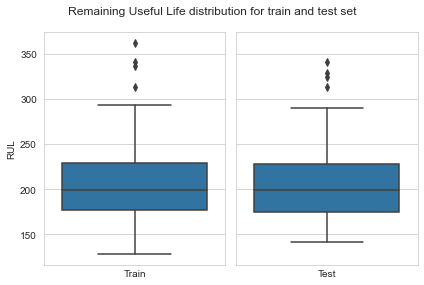

In [7]:
train_rul = n_cycles.time_cycles.values

# Test set overall RUL is sum of remaining cycles plus the number of cycles a machine has already ran
test_rul = test.groupby('unit_num').count().time_cycles.values + y_test.RUL.values

fig, axes = plt.subplots(1, 2, figsize=(6, 4), sharey=True)

sns.boxplot(data=train_rul, ax=axes[0])
sns.boxplot(data=test_rul, ax=axes[1])

axes[0].set_ylabel("RUL")
axes[0].set_xlabel("Train")
axes[0].set_xticks(ticks=[])

axes[1].set_xlabel("Test")
axes[1].set_xticks(ticks=[])

fig.suptitle("Remaining Useful Life distribution for train and test set")
plt.tight_layout()

plt.show()

**Distribution is quite similar for both sets**

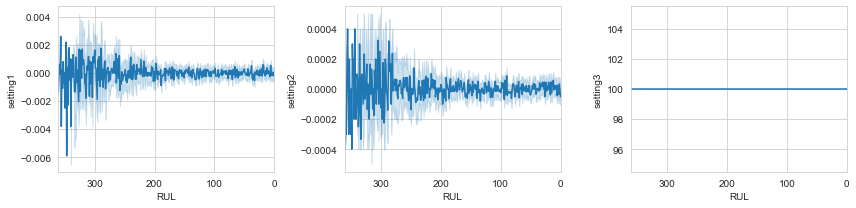

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for i, s in enumerate(setting_names):
    sns.lineplot(data=train, x="RUL", y=s, ax=axes[i])
    axes[i].set_xlim(max_rul, min_rul)

plt.tight_layout()
plt.show()

**Fluctuations gradually decrease in setting 1 and 2 as RUL decrease. Setting 3 doesn't change at all. All three columns can be discarded since they aren't telling us anything as the machine reaches its end-of-life.**

In [9]:
del_cols = ["setting1", "setting2", "setting3"]

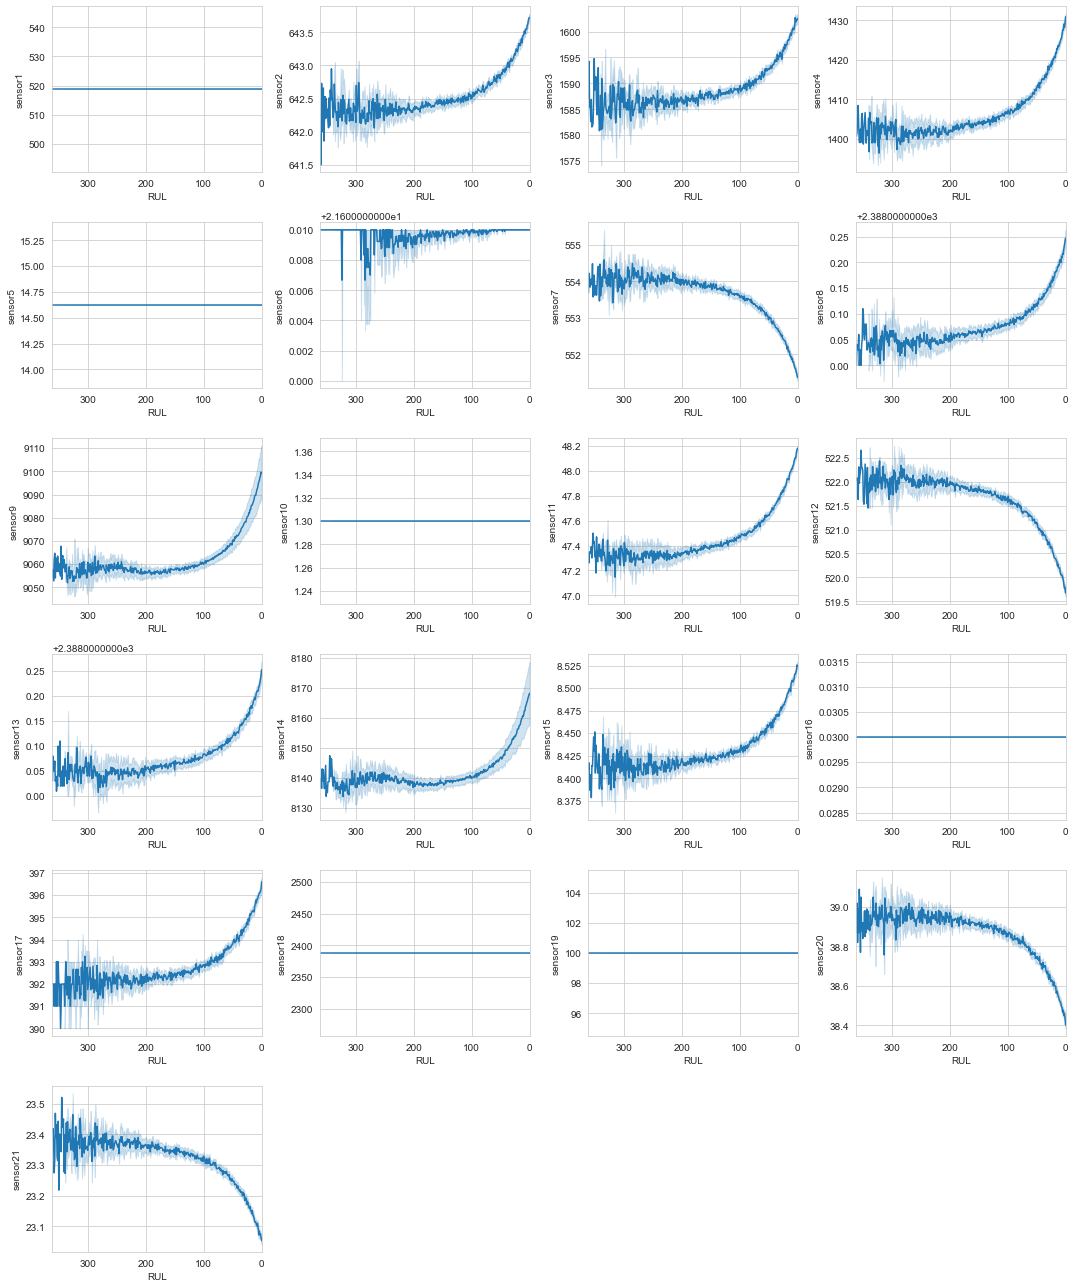

In [10]:
sensor_names = [f"sensor{i+1}" for i in range(21)]

fig, axes = plt.subplots(6, 4, figsize=(15, 18))

for i, s in enumerate(sensor_names):
    sns.lineplot(data=train, x="RUL", y=s, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_xlim(max_rul, min_rul)

axes.flat[-3].set_visible(False)
axes.flat[-2].set_visible(False)
axes.flat[-1].set_visible(False)
plt.tight_layout()
plt.show()

**Sensors 1, 5, 10, 16, 18 and 19 are constant. These can be dropped.**

In [11]:
del_cols += ["sensor1", "sensor5", "sensor10", "sensor16", "sensor18", "sensor19"]

**Sensor 6 stops changing as RUL decreases. It can be dropped as well.**

In [12]:
del_cols.append("sensor6")

**Sensor 9 and 14 have plots almost identical, could they be correlated with each other?**

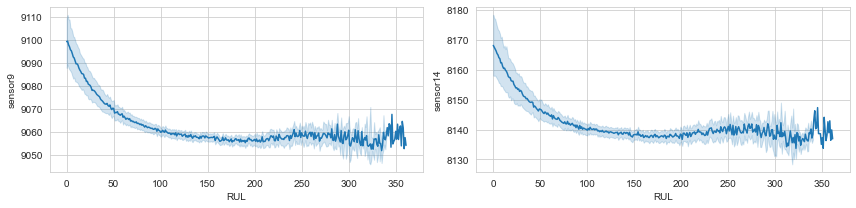

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

sns.lineplot(data=train, x="RUL", y="sensor9", ax=axes[0])
sns.lineplot(data=train, x="RUL", y="sensor14", ax=axes[1])

plt.tight_layout()

plt.show()

In [14]:
train[["sensor9", "sensor14"]].corr()

,sensor9,sensor14
sensor9,1.000000,0.963157
sensor14,0.963157,1.000000


**96% correlations. We can drop any one of them.**

In [16]:
del_cols.append("sensor14")

<b>Sensors 2, 3, 4, 8, 9, 11, 13, 15, and 17 shows increasing trend which means as the engine nears towards its end life, values of these sensors increase. Opposite is true for the sensors 7, 12, 20, and 21 which show decreasing trend.</b>

### Process and standardize train-test splits

In [17]:
del_cols += index_names

X_train = train.drop(del_cols, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_num').last().reset_index().drop(del_cols, axis=1)

scaler = StandardScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

X_train.shape, X_test.shape

((20631, 13), (100, 13))

### Build baseline models

In [18]:
def get_metrics(y, p, label):
    mae = mean_absolute_error(y, p)
    rmse = mean_squared_error(y, p, squared=False)
    r2 = r2_score(y, p)
    print(f'----- {label} -----\nRMSE: {round(rmse, 2)}\nMAE : {round(mae, 2)}\nR2  : {round(r2, 2)}\n')

In [19]:
def train_and_plot(model, X_train, y_train, X_test, y_test, plot):
    model = deepcopy(model)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    get_metrics(y_train, y_pred_train, "Train")

    y_pred_test = model.predict(X_test)
    get_metrics(y_test, y_pred_test, "Test")
    
    if plot:
        plt.figure(figsize=(5, 5))

        sns.regplot(x=y_test.RUL.values, y=y_pred_test, color='red', label="Linear fit")
        sns.scatterplot(x=y_test.RUL.values, y=y_pred_test, edgecolor='k')

        plt.xlabel("Actual RUL")
        plt.ylabel("Predicted RUL")
        plt.title("Actual vs predicted RUL for test set")

        plt.show()
    
    return model

**Linear Regression**

----- Train -----
RMSE: 44.69
MAE : 34.13
R2  : 0.58

----- Test -----
RMSE: 32.2
MAE : 25.64
R2  : 0.4



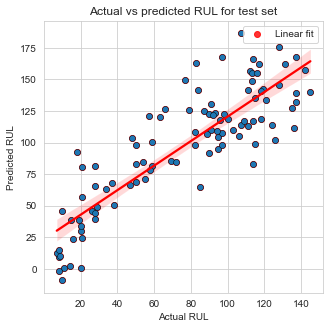

In [20]:
lm = LinearRegression()
lm = train_and_plot(lm, X_train, y_train, X_test, y_test, plot=True)

**Random Forest**

----- Train -----
RMSE: 36.8
MAE : 25.81
R2  : 0.71

----- Test -----
RMSE: 32.33
MAE : 23.98
R2  : 0.39



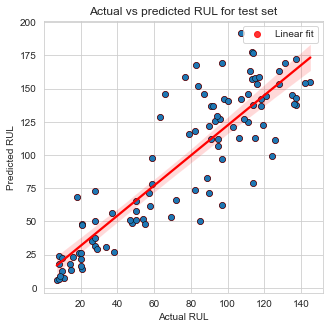

In [21]:
rf = RandomForestRegressor(max_depth=10, random_state=42, n_jobs=15)
rf = train_and_plot(rf, X_train, y_train, X_test, y_test, plot=True)

### Improve baseline models

**One big assumption we made is that RUL decreases linearly over time. Let's revisit that assumption. We see that, in many sensors, the values are often constant initially and there's sudden rise or fall in the values. This makes sense since the engines only develop a fault over time. The bend in the curve of the signal is the first bit of information provided to us that the engine is degrading and the first time it is reasonable to assume RUL is linearly declining. We can’t really say anything about the RUL before that point because we have no information about the initial wear and tear.**

**Therefore, we can update our assumption to reflect this logic. Instead of having our RUL decline linearly, we define our RUL to start out as a constant and only decline linearly after some time. By doing so we achieve two things:**<br><br>

<b>
    <ol>
        <li>Initially constant RUL correlates better with the initially constant mean sensor signal</li>
        <li>Lower peak values for RUL result in lower spread of our target variable, making it easier to fit a line</li>
    </ol>
</b>

In [22]:
y_train_clipped = y_train.clip(upper=125)  # 125 chose after some manual analysis

----- Train -----
RMSE: 21.52
MAE : 17.61
R2  : 0.73

----- Test -----
RMSE: 22.07
MAE : 17.79
R2  : 0.72



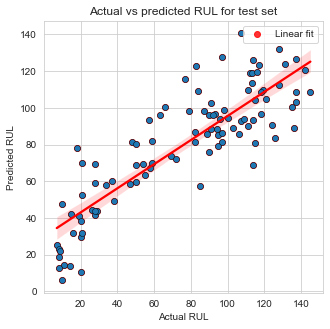

In [23]:
lm = LinearRegression()
lm = train_and_plot(lm, X_train, y_train_clipped, X_test, y_test, plot=True)

----- Train -----
RMSE: 17.16
MAE : 12.64
R2  : 0.83

----- Test -----
RMSE: 18.53
MAE : 13.64
R2  : 0.8



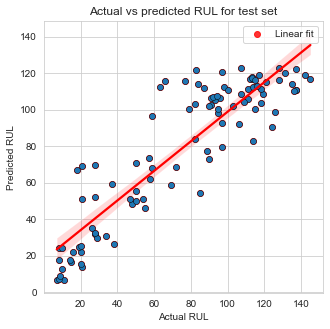

In [24]:
rf = RandomForestRegressor(max_depth=8, random_state=42, n_jobs=15)
rf = train_and_plot(rf, X_train, y_train_clipped, X_test, y_test, plot=True)

**This time both RMSE and R<sup>2</sup> improved significantly. RMSE shows an 42% decrease while R<sup>2</sup> increased by 105%. So we're on the right track. Let's check the feature importance score for the model.**

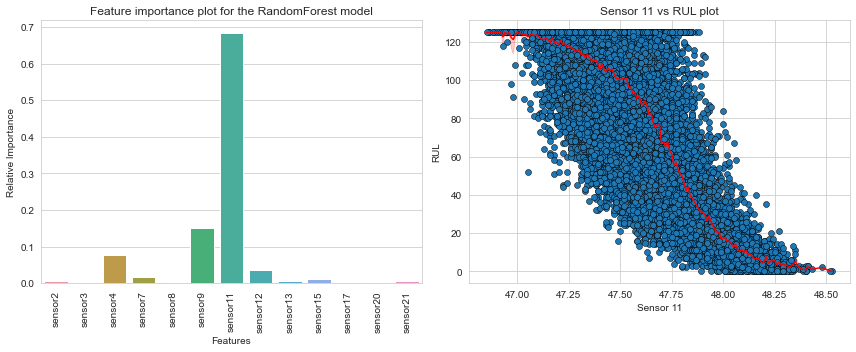

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=rf.feature_names_in_, y=rf.feature_importances_, ax=axes[0])
sns.lineplot(x=train["sensor11"], y=y_train_clipped, color='red', ax=axes[1])
sns.scatterplot(x=train["sensor11"], y=y_train_clipped, edgecolor='k', ax=axes[1])

axes[0].tick_params('x', labelrotation=90)
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Relative Importance")
axes[0].set_title("Feature importance plot for the RandomForest model")

axes[1].set_xlabel("Sensor 11")
axes[1].set_ylabel("RUL")
axes[1].set_title("Sensor 11 vs RUL plot")

plt.tight_layout()
plt.show()

**The left plot shows Sensor 11 to be highly important. The right plot shows a strong decreasing trend for Sensor 11 with RUL.**

### Survival Analysis

In [26]:
train2 = train.copy()
train2['RUL'] = train2['RUL'].clip(upper=125)  

train2.drop(del_cols[:-2], axis=1, inplace=True)
train2 = train2.reset_index(drop=True)

remaining_sensors = list(train2.columns)[2:-1]

**Add an event column**

In [27]:
train2['breakdown'] = 0

idx_last_record = train2.reset_index().groupby(by='unit_num')['index'].last()  # engines breakdown at the last cycle
train2.loc[idx_last_record, 'breakdown'] = 1

**Indicate the start and stop times of each observation**

In [28]:
train2['start'] = train2['time_cycles'] - 1 
train2.tail()

,unit_num,time_cycles,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor15,sensor17,sensor20,sensor21,RUL,breakdown,start
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1,0,198
20630,100,200,643.85,1600.38,1432.14,550.79,2388.26,9061.48,48.20,519.30,2388.26,8.5036,396,38.37,23.0522,0,1,199


**In the train set each engine is run to failure, therefore there aren’t any censored observations. We’ll artificially right-censor our dataset by disregarding any records after 200 time_cycles. This allows us to play around with the data in a bit more realistic setting, with a mix of engines which did and did not have their breakdown yet.**

In [29]:
cut_off = 200
train_censored = train2[train2.time_cycles <= cut_off].copy()

**KaplanMeier curve**

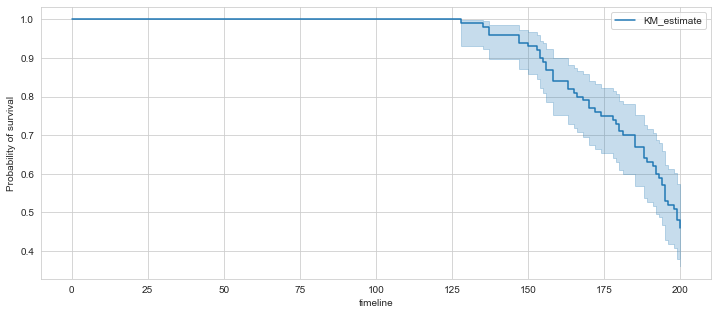

In [30]:
data = train_censored[index_names + ['breakdown']].groupby('unit_num').last()

plt.figure(figsize=(12, 5))

survival = KaplanMeierFitter()
survival.fit(data['time_cycles'], data['breakdown'])
survival.plot()

plt.ylabel("Probability of survival")
plt.show()

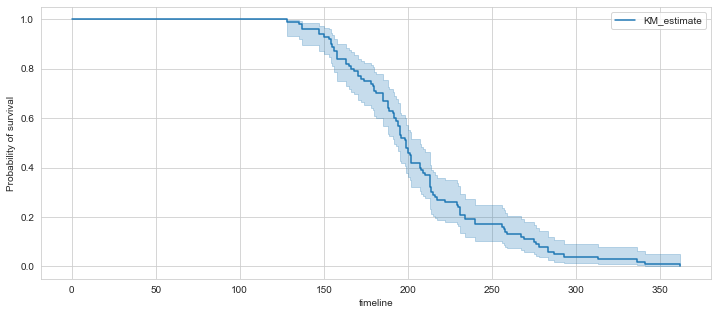

In [31]:
# Kaplan Meier without artificial censorship
data_km = train2[index_names + ['breakdown']].groupby('unit_num').last()

plt.figure(figsize=(12, 5))

survival = KaplanMeierFitter()
survival.fit(data_km['time_cycles'], data_km['breakdown'])
survival.plot()

plt.ylabel("Probability of survival")
plt.show()

In [32]:
from lifelines.utils import median_survival_times
median_ = survival.median_survival_time_
median_confidence_interval_ = median_survival_times(survival.confidence_interval_)
print(median_)
print(median_confidence_interval_)

199.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   192.0                   207.0


**100% probability of engine surviving before 128 cycles as expected since none of the engines broke down before that. There's also a ~45% probability of surviving past 200 cycles. The median survival time is 199 cycles.**

#### Cox Proportional Hazards models

In [33]:
# remaining_sensors.remove("sensor8")
# remaining_sensors.remove("sensor15")
# remaining_sensors.remove("sensor3")
# remaining_sensors.remove("sensor21")

In [34]:
train_cols = index_names + remaining_sensors + ['start', 'breakdown']
predict_cols = ['time_cycles'] + remaining_sensors + ['start', 'breakdown']  # breakdown value will be 0

ctv = CoxTimeVaryingFitter()
_ = ctv.fit(train_censored[train_cols], id_col="unit_num", event_col='breakdown', 
            start_col='start', stop_col='time_cycles', show_progress=True, fit_options={"step_size": 1})

Iteration 1: norm_delta = 0.92867, step_size = 1.00000, ll = -230.78680, newton_decrement = 107.09214, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.63084, step_size = 1.00000, ll = -107.03440, newton_decrement = 21.66986, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.68611, step_size = 1.00000, ll = -79.42341, newton_decrement = 9.23444, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.57493, step_size = 0.98000, ll = -67.82219, newton_decrement = 2.73295, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.24634, step_size = 0.96040, ll = -64.64995, newton_decrement = 0.30330, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.04194, step_size = 1.00000, ll = -64.32835, newton_decrement = 0.00674, seconds_since_start = 0.1
Iteration 7: norm_delta = 0.00074, step_size = 1.00000, ll = -64.32153, newton_decrement = 0.00000, seconds_since_start = 0.1
Iteration 8: norm_delta = 0.00000, step_size = 1.00000, ll = -64.32153, newton_decrement = 0.00000, seconds_since

<lifelines.CoxTimeVaryingFitter: fitted with 18627 periods, 100 subjects, 54 events>
         event col = 'breakdown'
number of subjects = 100
 number of periods = 18627
  number of events = 54
partial log-likelihood = -64.32
  time fit was run = 2023-03-04 20:08:42 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sensor2     2.11       8.28       0.71             0.71             3.51                 2.04                33.52
sensor3     0.06       1.07       0.04            -0.01             0.14                 0.99                 1.15
sensor4     0.17       1.18       0.05             0.07             0.26                 1.08                 1.29
sensor7    -1.03       0.36       0.50            -2.01            -0.05                 0.13                 0.95
sensor8    -4.94       0.01       4.85           -14.44             4.56                 0.00                95.63
sensor9     0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
sensor11    4.94     140.11       1.68             1.65             8.24                 5.20              3774.10
sensor12   -1.16       0.31       0.52            -2.18            -0.13                 0.11                 0.88
sensor13   12.39   2.40e+05       5.50             1.62            23.16                 5.03             1.14e+10
sensor15    5.90     364.46       9.46           -12.64            24.44                 0.00             4.12e+10
sensor17    0.43       1.54       0.20             0.03             0.83                 1.03                 2.28
sensor20   -4.94       0.01       2.01            -8.88            -0.99                 0.00                 0.37
sensor21   -4.04       0.02       2.67            -9.27             1.18                 0.00                 3.26

            cmp to     z      p   -log2(p)
covariate                                 
sensor2       0.00  2.96 <0.005       8.35
sensor3       0.00  1.61   0.11       3.23
sensor4       0.00  3.54 <0.005      11.27
sensor7       0.00 -2.07   0.04       4.68
sensor8       0.00 -1.02   0.31       1.70
sensor9       0.00  2.86 <0.005       7.89
sensor11      0.00  2.94 <0.005       8.26
sensor12      0.00 -2.20   0.03       5.18
sensor13      0.00  2.25   0.02       5.37
sensor15      0.00  0.62   0.53       0.91
sensor17      0.00  2.12   0.03       4.88
sensor20      0.00 -2.45   0.01       6.14
sensor21      0.00 -1.52   0.13       2.95
---
Partial AIC = 154.64
log-likelihood ratio test = 332.93 on 13 df
-log2(p) of ll-ratio test = 207.69

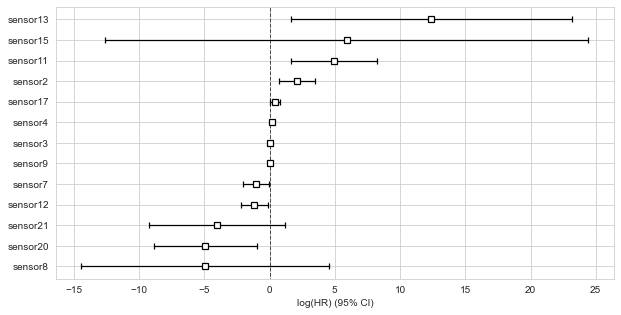

In [35]:
ctv.print_summary()

plt.figure(figsize=(10, 5))
ctv.plot()

plt.show()

**Sensor 8 and 15 have large p-values**

In [36]:
df1 = train_censored.groupby("unit_num").last()
df1 = df1[df1['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df1[df1['breakdown'] == 0].copy()

predictions = ctv.predict_log_partial_hazard(df_to_predict[predict_cols])
predictions = pd.DataFrame(predictions, columns=["predictions"])

df_last = train.groupby('unit_num').last()
predictions['RUL'] = df_to_predict['RUL'].values
predictions.head(10)

,predictions,RUL
0,-1.089600,87
1,-1.652427,69
2,3.627801,59
3,21.125999,1
4,11.641026,22
5,4.440564,40
6,14.643717,7
7,20.809963,9
8,-3.333209,76
9,10.597310,34


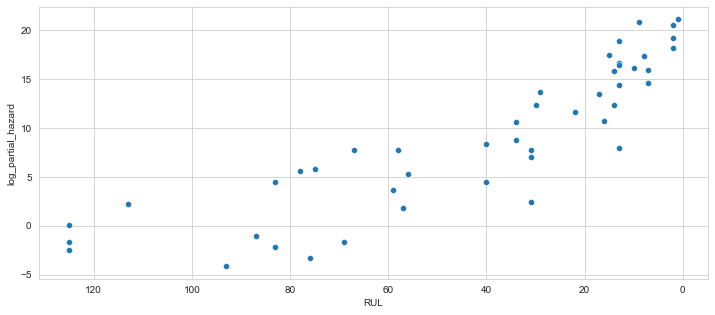

In [37]:
plt.figure(figsize=(12, 5))

sns.scatterplot(x=predictions['RUL'], y=predictions['predictions'])

xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')

plt.show()

In [38]:
from scipy.optimize import curve_fit

def exponential_model(z, a, b):
    return a * np.exp(-b * z)

In [39]:
train3 = train2.copy() # create another copy for later
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(train2[train_cols], id_col="unit_num", event_col='breakdown', 
        start_col='start', stop_col='time_cycles', show_progress=False)

train2['hazard'] = ctv2.predict_log_partial_hazard(train2)
popt2, pcov2 = curve_fit(exponential_model, train2['hazard'], train2['RUL'])

y_hat = exponential_model(train2['hazard'], *popt2)
get_metrics(train2['RUL'], y_hat, 'Train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('unit_num').last())
y_hat = exponential_model(y_pred, *popt2)
get_metrics(y_test, y_hat, "Test")

----- Train -----
RMSE: 26.22
MAE : 22.48
R2  : 0.6

----- Test -----
RMSE: 26.61
MAE : 23.08
R2  : 0.59



**Partial Effects on Survival**

In [40]:
train3.describe() # for the partial effects plots, we will use min, 25%, 50%, 75%, and max values

,unit_num,time_cycles,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor15,sensor17,sensor20,sensor21,RUL,breakdown,start
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,642.680934,1590.523119,1408.933782,553.367711,2388.096652,9065.242941,47.541168,521.413470,2388.096152,8.442146,393.210654,38.816271,23.289705,86.829286,0.004847,107.807862
std,29.227633,68.880990,0.500053,6.131150,9.000605,0.885092,0.070985,22.082880,0.267087,0.737553,0.071919,0.037505,1.548763,0.180746,0.108251,41.673699,0.069454,68.880990
min,1.000000,1.000000,641.210000,1571.040000,1382.250000,549.850000,2387.900000,9021.730000,46.850000,518.690000,2387.880000,8.324900,388.000000,38.140000,22.894200,0.000000,0.000000,0.000000
25%,26.000000,52.000000,642.325000,1586.260000,1402.360000,552.810000,2388.050000,9053.100000,47.350000,520.960000,2388.040000,8.414900,392.000000,38.700000,23.221800,51.000000,0.000000,51.000000
50%,52.000000,104.000000,642.640000,1590.100000,1408.040000,553.440000,2388.090000,9060.660000,47.510000,521.480000,2388.090000,8.438900,393.000000,38.830000,23.297900,103.000000,0.000000,103.000000
75%,77.000000,156.000000,643.000000,1594.380000,1414.555000,554.010000,2388.140000,9069.420000,47.700000,521.950000,2388.140000,8.465600,394.000000,38.950000,23.366800,125.000000,0.000000,155.000000
max,100.000000,362.000000,644.530000,1616.910000,1441.490000,556.060000,2388.560000,9244.590000,48.530000,523.380000,2388.560000,8.584800,400.000000,39.430000,23.618400,125.000000,1.000000,361.000000


<AxesSubplot:>

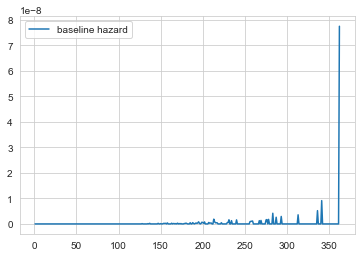

In [44]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(train3, duration_col='time_cycles', event_col='breakdown',
        formula='sensor2 + sensor3 + sensor4 + sensor7 + sensor8 + sensor9 + sensor11 + sensor12 + sensor13 + sensor15 + sensor17 + sensor20 + sensor21')
cph.baseline_hazard_.plot()

<AxesSubplot:xlabel='log(HR) (95% CI)'>

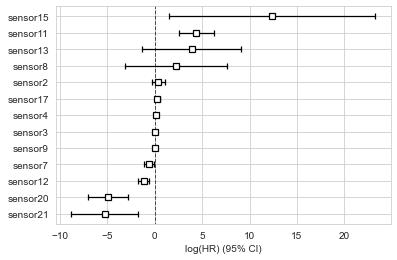

In [42]:
cph.plot()

**Among statistically significant predictors, sensor11 and sensor20 have the most pronounced effect.**

In [103]:
train3_copy = train3.copy()

In [104]:
train3_copy = train3_copy.drop(columns=['RUL'])
train3_copy.head()

,unit_num,time_cycles,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor15,sensor17,sensor20,sensor21,breakdown,start
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,0,4


C:\Users\ianmv\anaconda3attempt2\lib\site-packages\lifelines\utils\__init__.py:1165: ConvergenceWarning: Column start has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\ianmv\anaconda3attempt2\lib\site-packages\lifelines\fitters\coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


<AxesSubplot:>

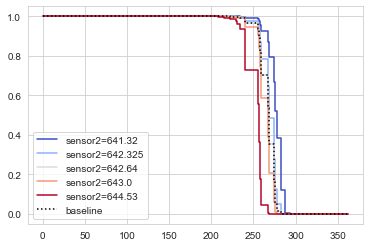

In [105]:
cph.fit(train3_copy, duration_col='time_cycles', event_col='breakdown')
cph.plot_partial_effects_on_outcome('sensor2', values=(641.32, 642.325, 642.64, 643, 644.53), cmap='coolwarm')

<AxesSubplot:>

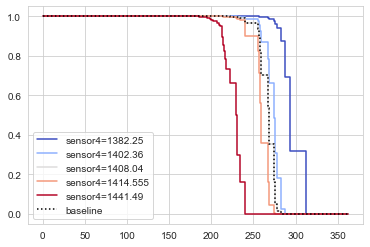

In [106]:
cph.plot_partial_effects_on_outcome('sensor4', values=(1382.25, 1402.36, 1408.04, 1414.555, 1441.49), cmap='coolwarm')

<AxesSubplot:>

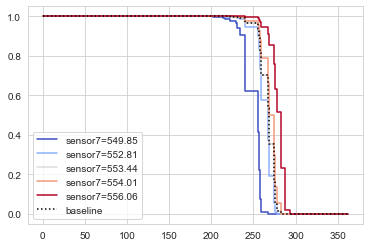

In [107]:
cph.plot_partial_effects_on_outcome('sensor7', values=(549.85, 552.81, 553.44, 554.01, 556.06), cmap='coolwarm')

<AxesSubplot:>

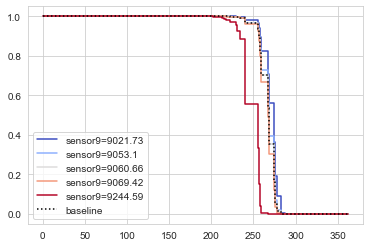

In [108]:
cph.plot_partial_effects_on_outcome('sensor9', values=(9021.73, 9053.1, 9060.66, 9069.42, 9244.59), cmap='coolwarm')

<AxesSubplot:>

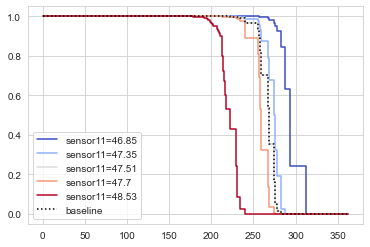

In [109]:
cph.plot_partial_effects_on_outcome('sensor11', values=(46.85, 47.35, 47.51, 47.7, 48.53), cmap='coolwarm')

<AxesSubplot:>

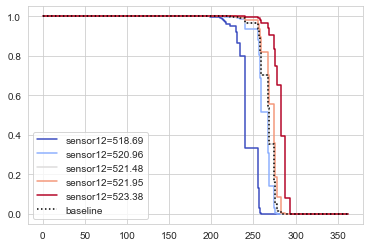

In [110]:
cph.plot_partial_effects_on_outcome('sensor12', values=(518.69, 520.96, 521.48, 521.95, 523.38), cmap='coolwarm')

<AxesSubplot:>

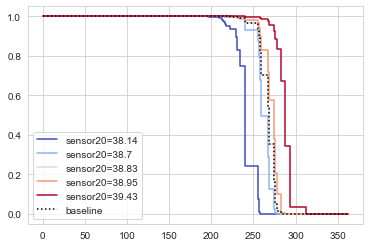

In [111]:
cph.plot_partial_effects_on_outcome('sensor20', values=(38.14, 38.7, 38.83, 38.95, 39.43), cmap='coolwarm')

**WeibullAFTFitter**

In [58]:
from lifelines import WeibullFitter
wb = WeibullFitter()

In [59]:
wb.fit(data_km['time_cycles'],data_km['breakdown'])

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 100 total observations, 0 right-censored observations>

<AxesSubplot:>

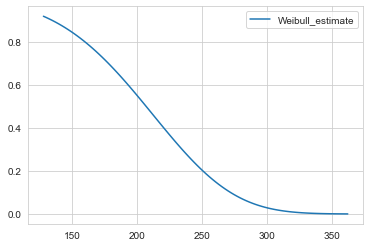

In [60]:
wb.survival_function_.plot()

In [61]:
print(wb.lambda_,wb.rho_)

225.02585413831693 4.408714937980028


**Rho parameter is greater than 1. This is illustrated with the convex survival curve and indicates machines are more likely to fail later in their existence.**

In [64]:
from lifelines import WeibullAFTFitter
aft=WeibullAFTFitter()
aft.fit(train3,duration_col='time_cycles',event_col='breakdown',
       formula='sensor2 + sensor3 + sensor4 + sensor7 + sensor8 + sensor9 + sensor11 + sensor12 + sensor13 + sensor15 + sensor17 + sensor20 + sensor21')

<lifelines.WeibullAFTFitter: fitted with 20631 total observations, 20531 right-censored observations>

In [65]:
aft.summary

coef   exp(coef)     se(coef)  coef lower 95%  \
param   covariate                                                      
lambda_ Intercept  6.123315  456.374994  1327.330908    -2595.397461   
        sensor11  -0.857384    0.424270     0.190814       -1.231372   
        sensor12   0.264933    1.303343     0.071222        0.125341   
        sensor13  -0.486744    0.614625     0.618598       -1.699173   
        sensor15  -2.026147    0.131842     1.160126       -4.299953   
        sensor17  -0.085779    0.917797     0.025228       -0.135226   
        sensor2   -0.094547    0.909785     0.075200       -0.241935   
        sensor20   1.068265    2.910325     0.231567        0.614403   
        sensor21   1.259179    3.522530     0.388244        0.498236   
        sensor3   -0.008909    0.991131     0.005857       -0.020389   
        sensor4   -0.037477    0.963217     0.006401       -0.050023   
        sensor7    0.132004    1.141113     0.059296        0.015786   
        sensor8    0.469337    1.598934     0.586511       -0.680203   
        sensor9   -0.001975    0.998027     0.000697       -0.003340   
rho_    Intercept  1.547960    4.701868     0.084085        1.383157   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                             
lambda_ Intercept     2607.644091             0.000000                  inf   
        sensor11        -0.483397             0.291892             0.616685   
        sensor12         0.404525             1.133535             1.498590   
        sensor13         0.725686             0.182835             2.066148   
        sensor15         0.247659             0.013569             1.281023   
        sensor17        -0.036333             0.873519             0.964319   
        sensor2          0.052841             0.785107             1.054262   
        sensor20         1.522127             1.848552             4.581962   
        sensor21         2.020123             1.645815             7.539255   
        sensor3          0.002572             0.979818             1.002575   
        sensor4         -0.024931             0.951208             0.975378   
        sensor7          0.248223             1.015911             1.281745   
        sensor8          1.618877             0.506514             5.047420   
        sensor9         -0.000609             0.996666             0.999391   
rho_    Intercept        1.712763             3.987468             5.544260   

                   cmp to          z             p    -log2(p)  
param   covariate                                               
lambda_ Intercept     0.0   0.004613  9.963192e-01    0.005320  
        sensor11      0.0  -4.493309  7.012493e-06   17.121641  
        sensor12      0.0   3.719832  1.993554e-04   12.292369  
        sensor13      0.0  -0.786850  4.313697e-01    1.213003  
        sensor15      0.0  -1.746488  8.072613e-02    3.630820  
        sensor17      0.0  -3.400132  6.735333e-04   10.535963  
        sensor2       0.0  -1.257280  2.086521e-01    2.260828  
        sensor20      0.0   4.613207  3.965030e-06   17.944237  
        sensor21      0.0   3.243270  1.181661e-03    9.724968  
        sensor3       0.0  -1.520923  1.282792e-01    2.962641  
        sensor4       0.0  -5.854641  4.780415e-09   27.640217  
        sensor7       0.0   2.226183  2.600193e-02    5.265237  
        sensor8       0.0   0.800219  4.235839e-01    1.239280  
        sensor9       0.0  -2.834798  4.585465e-03    7.768716  
rho_    Intercept     0.0  18.409496  1.102433e-75  249.003916

**The sign on all exp(coef)'s is positive, indicating machines are more likely to fail as sensor readings increase. All sensors are statistically significant at alpha = 0.05. Sensor 20 and Sensor 21 have the most outsized effect on average survival time in regards to a one-unit change in the covariates.**

In [67]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter
Ex=ExponentialFitter()
LN=LogNormalFitter()
Ex.fit(train3['time_cycles'],train3['breakdown'])
LN.fit(train3['time_cycles'],train3['breakdown'])

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 20631 total observations, 20531 right-censored observations>

In [68]:
print(aft.AIC_,Ex.AIC_,LN.AIC_)

1381.2254314026889 2205.792696885936 1809.6642183964975


**AIC is lowest on the AFT model, indicating Weibull curve fits the data better than Exponential or LogNormal curves.**

In [69]:
from lifelines import utils
best_model, best_aic= utils.find_best_parametric_model(train3['time_cycles'],train3['breakdown'], scoring_method='AIC')
print(best_model)

<lifelines.SplineFitter:"SplineFitter: 1 internal knot", fitted with 20631 total observations, 20531 right-censored observations>


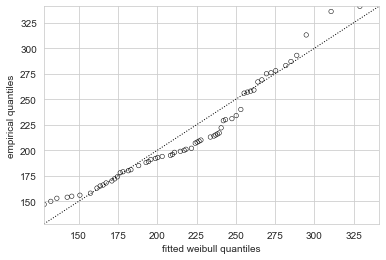

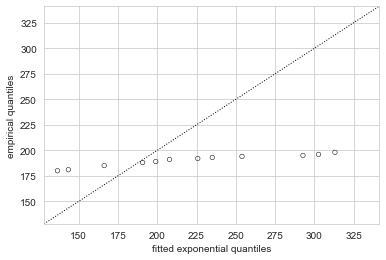

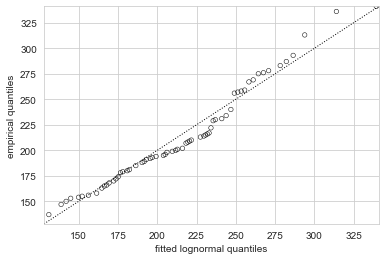

In [71]:
from lifelines.plotting import qq_plot
from lifelines import PiecewiseExponentialFitter
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter
import matplotlib.pyplot as plt
lst=[WeibullFitter(),ExponentialFitter(),LogNormalFitter()]

for model in lst:
    model.fit(train3['time_cycles'],train3['breakdown'])
    qq_plot(model)
    plt.show()

<AxesSubplot:>

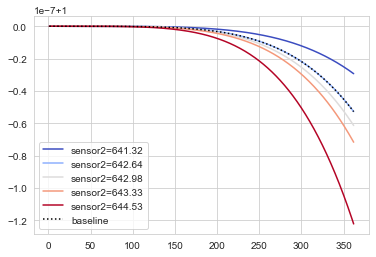

In [72]:
aft.plot_partial_effects_on_outcome('sensor2', values=(641.32, 642.64, 642.98, 643.33, 644.53), cmap='coolwarm')

<AxesSubplot:>

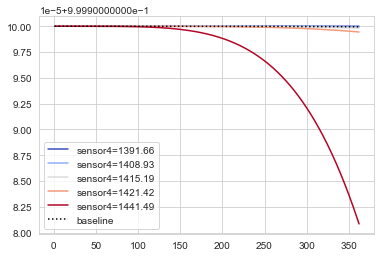

In [73]:
aft.plot_partial_effects_on_outcome('sensor4', values=(1391.66, 1408.93, 1415.19, 1421.42, 1441.49), cmap='coolwarm')

<AxesSubplot:>

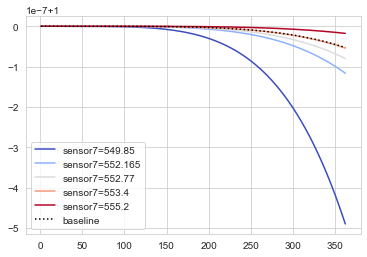

In [74]:
aft.plot_partial_effects_on_outcome('sensor7', values=(549.85, 552.165, 552.77, 553.4, 555.2), cmap='coolwarm')

<AxesSubplot:>

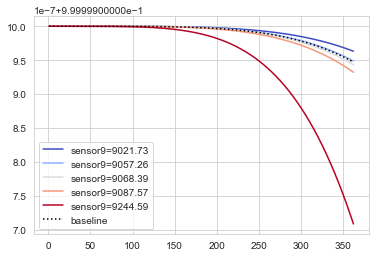

In [75]:
aft.plot_partial_effects_on_outcome('sensor9', values=(9021.73, 9057.26, 9068.39, 9087.57, 9244.59), cmap='coolwarm')

<AxesSubplot:>

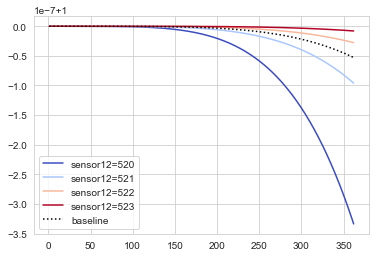

In [76]:
aft.plot_partial_effects_on_outcome('sensor12', values=(520, 521, 522, 523), cmap='coolwarm')

<AxesSubplot:>

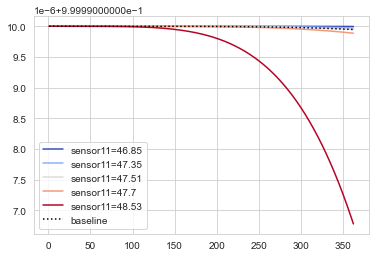

In [77]:
aft.plot_partial_effects_on_outcome('sensor11', values=(46.85, 47.35, 47.51, 47.7, 48.53), cmap='coolwarm')

<AxesSubplot:>

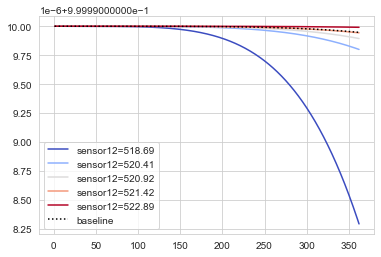

In [78]:
aft.plot_partial_effects_on_outcome('sensor12', values=(518.69, 520.41, 520.92, 521.42, 522.89), cmap='coolwarm')

In [513]:
#aft.fit(train3_copy,duration_col='time_cycles',event_col='breakdown',
#       formula='sensor2 + sensor3 + sensor4 + sensor7 + sensor8 + sensor9 + sensor11 + sensor12 + sensor13 + sensor15 + sensor17 + sensor20 + sensor21')
#
#df_aft = train3_copy.groupby('unit_num').last()
#df_aft = df_aft[df_aft['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
#df_aft_to_predict = df_aft[df_aft['breakdown'] == 0].copy()

#predictions_aft = aft.predict_remaining_lifetime(df_aft_to_predict[remaining_sensors])
#predictions_aft = pd.DataFrame(predictions_aft, columns=['predictions'])

#df_aft_last = train.groupby('unit_num').last()
#predictions_aft['RUL'] = df_aft_to_predict['RUL'].values
#predictions_aft.head(10)

#from sklearn.model_selection import train_test_split

#y_aft = train_copy3['']

#X_train, X_test, y_train, y_test = train_test_split(
#...     X, y, test_size=0.33, random_state=42)